# Extract airport data (ex: runway geocoordinates) from OpenStreetMap with Python tools

#### OpenStreetMap data can be found here: https://www.openstreetmap.org/

In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

In [3]:
airport_icao_code = "LFBO"  # Toulouse–Blagnac Airport
osm_filter = '["aeroway"~"runway|taxiway|apron|control_tower|control_center|gate|hangar|helipad|heliport|navigationaid|taxilane|terminal|windsock|highway_strip|parking_position|holding_position|airstrip|stopway|tower"]'
# you can find other tags linked to airports here: https://wiki.openstreetmap.org/wiki/Key:aeroway

#### <br> Use OSMnx Python package to extract OSM data as graphs/geodataframes

In [4]:
G = ox.graph_from_place(
    airport_icao_code,
    simplify=False,
    retain_all=True,
    truncate_by_edge=True,
    buffer_dist=1000,
    custom_filter=osm_filter,
)

#### Plot all airport data

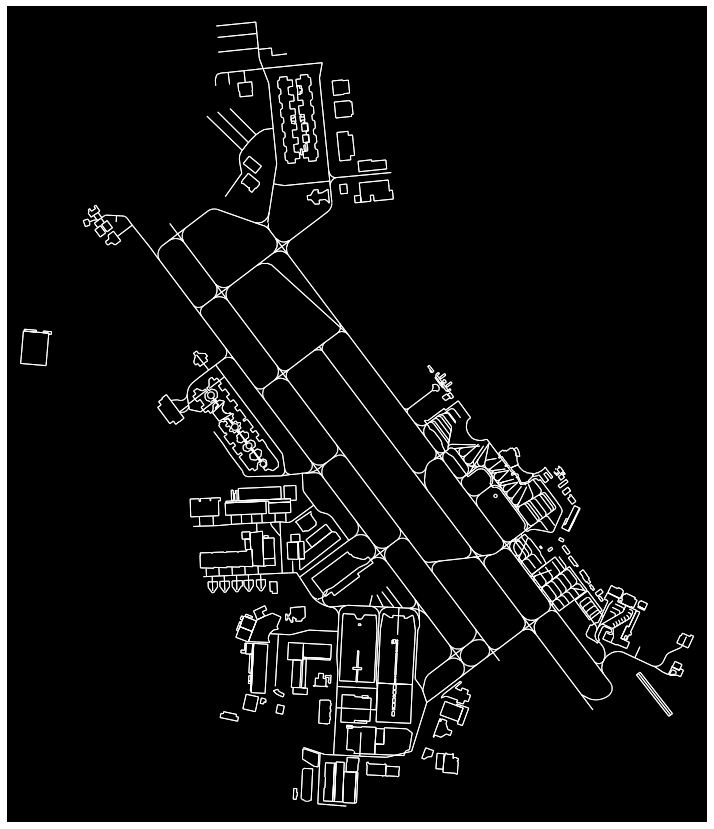

In [5]:
f, ax = ox.plot_graph(
    G,
    figsize=(15, 15),
    bgcolor="black",
    edge_color="white",
    edge_linewidth=1,
    node_size=0,
    show=True,
)

#### Put airport data in geodataframes

In [6]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges.head()

osmid        ref    name  oneway  length area  \
u         v          key                                                      
56531223  2879442606 0     64419169          B  Hall B   False   6.003  NaN   
          792426226  0     64419169          B  Hall B   False  16.875  NaN   
                     1    284184579          A  Hall A   False  16.875  NaN   
          2879442505 0    284184579          A  Hall A   False   5.865  NaN   
161644129 4644120876 0    161702026  Blagnac 2     NaN   False  58.212  NaN   

                         width bridge  \
u         v          key                
56531223  2879442606 0     NaN    NaN   
          792426226  0     NaN    NaN   
                     1     NaN    NaN   
          2879442505 0     NaN    NaN   
161644129 4644120876 0     NaN    NaN   

                                                                 geometry  
u         v          key                                                   
56531223  2879442606 0    LINESTRING (1.37530 43.62959, 1.37524 43.62955)  
          792426226  0    LINESTRING (1.37530 43.62959, 1.37525 43.62974)  
                     1    LINESTRING (1.37530 43.62959, 1.37525 43.62974)  
          2879442505 0    LINESTRING (1.37530 43.62959, 1.37525 43.62955)  
161644129 4644120876 0    LINESTRING (1.37755 43.62774, 1.37714 43.62817)

In [7]:
gdf_edges.name.unique()

array(['Hall B', 'Hall A', nan, 'C32', 'Charlie', 'L35', 'TWR', 'Hall C',
       'Air France Industries', "Aéroport d'affaire", 'H16', 'H11', 'L34',
       'H10', 'L02', 'L03', 'C91', 'M24', 'M15', 'M67', 'M75', 'M63',
       'M16', 'Landes', 'M18', 'M89', 'M81', 'Pyrénées', 'Tarn', 'C82',
       'C40', 'C42', 'C35', 'A40', 'Airbus Delivery Centre C84', 'C02',
       'C21', 'C04', 'C22', 'C03', 'C23', 'C01', 'C61', 'C62', 'C65',
       'C64', 'C66', 'M55', 'M50', 'M90', 'A29', 'M91', 'M96', 'M62',
       'A08', 'A43', 'A30', 'A09', 'Tango', '14H/32H', 'Vendée', 'Morvan',
       'Bikini', 'M70', 'A50', 'A55', '14R/32L', '14L/32R', 'LD13',
       'Quercy', 'C81'], dtype=object)

#### <br> Let's focus on the main runway named '14L/32R'

In [8]:
runway_gdf = gdf_edges.query('name=="14L/32R"')
runway_gdf_3857 = runway_gdf.to_crs(epsg=3857)  # web mercator projection
runway_gdf_3857.head()

osmid      ref     name  oneway   length area  \
u          v          key                                                      
3737038383 3845883425 0    369970582  14L/32R  14L/32R   False   29.697  NaN   
3737038384 4935152331 0    369970582  14L/32R  14L/32R   False   30.279  NaN   
3845882371 4935152331 0    369970582  14L/32R  14L/32R   False   95.777  NaN   
           3845882595 0    369970582  14L/32R  14L/32R   False  501.900  NaN   
3845882595 3845882371 0    369970582  14L/32R  14L/32R   False  501.900  NaN   

                          width bridge  \
u          v          key                
3737038383 3845883425 0      45    NaN   
3737038384 4935152331 0      45    NaN   
3845882371 4935152331 0      45    NaN   
           3845882595 0      45    NaN   
3845882595 3845882371 0      45    NaN   

                                                                    geometry  
u          v          key                                                     
3737038383 3845883425 0    LINESTRING (151139.274 5409481.631, 151163.954...  
3737038384 4935152331 0    LINESTRING (153645.209 5406155.779, 153620.018...  
3845882371 4935152331 0    LINESTRING (153540.313 5406294.994, 153620.018...  
           3845882595 0    LINESTRING (153540.313 5406294.994, 153122.642...  
3845882595 3845882371 0    LINESTRING (153122.642 5406849.307, 153540.313...

#### Transform linestring/width into shapely polygons 

In [9]:
runway_gdf_3857["geometry"] = runway_gdf_3857.apply(
    lambda x: x.geometry.buffer(float(x.width) / 2, cap_style=3), axis=1
)
runway_gdf_3857.head()

osmid      ref     name  oneway   length area  \
u          v          key                                                      
3737038383 3845883425 0    369970582  14L/32R  14L/32R   False   29.697  NaN   
3737038384 4935152331 0    369970582  14L/32R  14L/32R   False   30.279  NaN   
3845882371 4935152331 0    369970582  14L/32R  14L/32R   False   95.777  NaN   
           3845882595 0    369970582  14L/32R  14L/32R   False  501.900  NaN   
3845882595 3845882371 0    369970582  14L/32R  14L/32R   False  501.900  NaN   

                          width bridge  \
u          v          key                
3737038383 3845883425 0      45    NaN   
3737038384 4935152331 0      45    NaN   
3845882371 4935152331 0      45    NaN   
           3845882595 0      45    NaN   
3845882595 3845882371 0      45    NaN   

                                                                    geometry  
u          v          key                                                     
3737038383 3845883425 0    POLYGON ((151181.941 5409462.309, 151195.458 5...  
3737038384 4935152331 0    POLYGON ((153602.046 5406175.684, 153588.509 5...  
3845882371 4935152331 0    POLYGON ((153637.987 5406202.762, 153651.528 5...  
           3845882595 0    POLYGON ((153104.673 5406835.767, 153091.132 5...  
3845882595 3845882371 0    POLYGON ((153558.283 5406308.534, 153571.823 5...

#### Plot the geometrical objects on a background map to check if runway data are correct

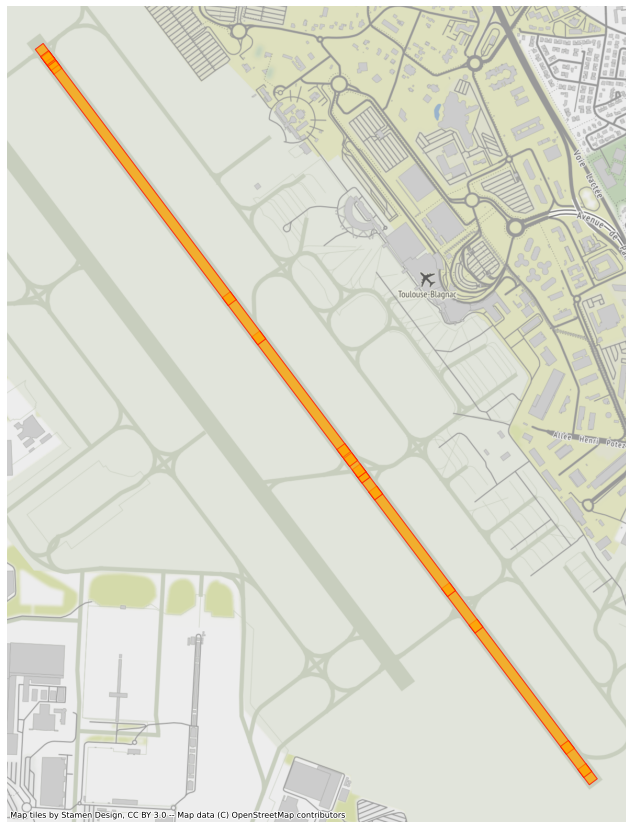

In [10]:
ax = runway_gdf_3857.plot(figsize=(15, 15), alpha=0.5, edgecolor="red", color="orange")
ctx.add_basemap(ax, zoom=16)
ax.set_axis_off()
plt.savefig("runway_airport.png", dpi=300, bbox_inches="tight")